In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot_params import * 
from scipy.spatial.distance import cdist
import math
from copy import deepcopy
from numpy.linalg import norm
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython import display

In [235]:
def Generate_charges(n_charges, radius):
    r = radius * np.sqrt(np.random.rand(n_charges))
    theta = np.random.rand(n_charges) * 2 * np.pi
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.array([[a, b] for a,b in zip(x,y)])

def Calculate_Etot(positions, n_charges, radius):
    dist = cdist(positions,positions,'euclidean')
    #print(1/dist[dist>0])
    #print(np.sum(1/dist[dist>0]))
    return 1/2*np.sum(1/dist[dist>0])

def Calculate_step(positions, i_particle, step_constant):
    #dist = cdist(positions,positions,'euclidean')
    #dist = dist[:,i_particle]
    #Etot = np.sum(1/dist[dist>0])
    xpos = positions[:,0]
    ypos = positions[:,1]

    x_dist =  xpos.reshape(-1, 1) - xpos
    x_step = x_dist[i_particle]
    x_step = x_step[x_step!=0]

    y_dist = ypos.reshape(-1, 1) - ypos
    y_step = y_dist[i_particle]
    y_step = y_step[y_step!=0]

    x_step = np.sum(x_step/np.sqrt(x_step**2+y_step**2)**3)
    y_step = np.sum(y_step/np.sqrt(x_step**2+y_step**2)**3)
    
    force = step_constant*np.array([x_step, y_step])
    #(np.array([x_step, y_step])/(math.sqrt(x_step**2+y_step**2))**3)
    return force

def Inside_circle(point, r_max):
    r = math.sqrt(point[0]**2+point[1]**2)
    #print(point,r)
    #print(r<=r_max)
    return r<=r_max

def Random_step_centre(angle, step_size):
    angle = np.pi+angle
    random_angle = np.random.uniform(angle-np.pi/4, angle+np.pi/4)
    #random_angle = np.pi+angle
    #random_angle = np.pi
    #print(random_angle/np.pi)
    random_radius = step_size*np.random.rand()
    x = random_radius * np.cos(random_angle)
    #print(random_angle/np.pi, np.cos(random_angle))
    y = random_radius * np.sin(random_angle)
    return np.array([x,y])

def Cooling_schedule(T_init, n_steps, constant):
    T = np.zeros(n_steps)
    for i in range(n_steps):
        T[i] = T_init*pow(constant,i)
    return T

In [234]:
n_charges = 5
step_constant = 0.5
radius = 1
pos_init = Generate_charges(n_charges, radius)
T_initial = 10
n_steps = 100
Temp = Cooling_schedule(T_initial, n_steps, 0.997)
ims = []
constant = np.array([0.05, 0.001])

In [222]:
T_initial = 50
#alpha T 0.99
#T_init = 1 at 3, 2 at 4, 5 and 6. 3 at 7, 25 at 8, 80 at 9
#1000 steps below 9.

#2000 steps at 10 with alpha T 0.995
#T_init = 130 at 10

#4000 steps at 11 with alpha T 0.997
#T_init = 60 at 11
Temp = Cooling_schedule(T_initial, n_steps, 0.999)

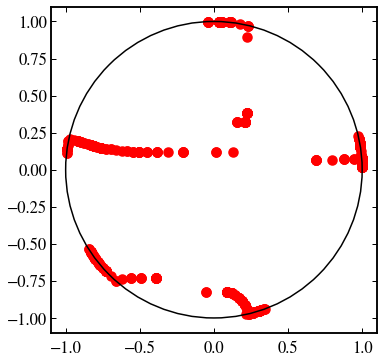

In [245]:
T = T_initial
pos = deepcopy(pos_init)
ims = []
j = 0
fig = plt.figure()
circle1 = plt.Circle((0,0),radius, fill=False)
plt.gca().add_patch(circle1)
plt.axis('square')
test = np.zeros(n_steps)
#plt.scatter(pos[:,0], pos[:,1])
step_constant = 0.02
constant = 1
for i in range(n_steps):
    T = Temp[i]
    E_tot = Calculate_Etot(pos, radius, n_charges)
    i_particle = np.random.randint(n_charges)
    #step_constant = constant[j]*E_tot**2
    
    step = Calculate_step(pos, i_particle, step_constant)
    #print(step)
    pos_new = deepcopy(pos)
    pos_new[i_particle, :]= pos[i_particle,:] + step
    step_size = math.sqrt(step[0]**2+step[1]**2)
    if not Inside_circle(pos_new[i_particle, :],radius):
        dist_to_circle = radius-math.sqrt(pos[i_particle, :][0]**2+pos[i_particle, :][1]**2)
        #step_size = math.sqrt(step[0]**2+step[1]**2)
        step_angle = np.arctan2(step[1], step[0])
        
        point_angle = np.arctan2(pos[i_particle, 1], pos[i_particle, 0])
        
        angle_dif = step_angle-point_angle
        arc_length = step_size-dist_to_circle
        arc_angle = math.copysign(arc_length / radius,angle_dif)
        
        random_step = Random_step_centre(point_angle,0.5)
        #pos_new[i_particle, :]= pos[i_particle,:]+random_step*constant
        
        pos_new[i_particle, 0] = math.cos(point_angle+arc_angle)*radius
        pos_new[i_particle, 1] = math.sin(point_angle+arc_angle)*radius
    E_new = Calculate_Etot(pos_new, radius, n_charges)
    delta_E = E_new - E_tot
    u = np.random.rand()
    alpha = min(math.exp(-delta_E/T), 1)
    test[i] = alpha
    #test[i] = delta_E
    if (u <= alpha):
        pos = pos_new
    #step_constant=step_constant*0.9999
    constant = constant*0.97
    #plt.scatter(pos[:,0], pos[:,1])
    
    im = plt.scatter(pos[:,0], pos[:,1], c='r')
    ims.append([im])
    
#ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
#writer = PillowWriter(fps=60)
#ani.save("demo2.gif", writer=writer)

In [224]:
#fig = plt.figure()

#plt.show()
ani = animation.ArtistAnimation(fig, ims, interval = 100, blit=True)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close() 
#writer = PillowWriter(fps=n_steps)
#ani.save("demo2.gif", writer=writer)

[0.71770912 0.72396262 0.84534003 0.9900811  1.11775378 1.071439
 1.17285272 1.00632832 0.86600409 0.99399579 0.91365786 0.76802081]


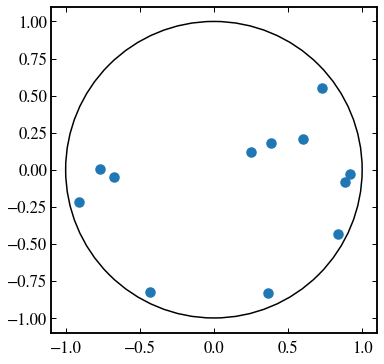

In [217]:
plt.scatter(pos[:,0], pos[:,1])
circle1 = plt.Circle((0,0),radius, fill=False)
plt.gca().add_patch(circle1)
plt.axis('square')
dist = cdist(pos,pos,'euclidean')
print(1/n_charges*np.sum(dist, axis=0))

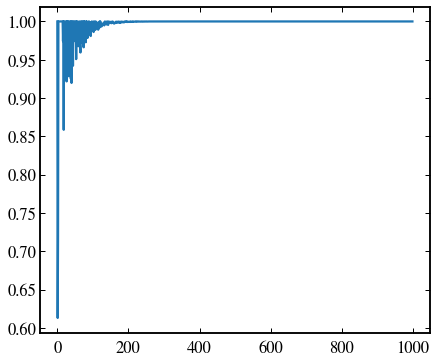

In [213]:
plt.plot(test)